In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    
    return inputs_real, inputs_z

In [4]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha*h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.nn.tanh(logits)
        
        return out, logits

In [5]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha*h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.nn.sigmoid(logits)
        
        return out, logits

In [6]:
# Size of input image to discriminator
input_size = 784 # 28x28 MNIST images flattened
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1

In [7]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Generator network here
g_model, g_logits = generator(input_z, input_size, g_hidden_size, reuse=False,  alpha=alpha)
# g_model is the generator output

# Disriminator network here
d_model_real, d_logits_real = discriminator(input_real, d_hidden_size, reuse=False, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, d_hidden_size, reuse=True, alpha=alpha)

In [8]:
# Calculate losses
d_labels_real = tf.ones_like(d_logits_real) * (1 - smooth)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_real, logits=d_logits_real)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_fake, logits=d_logits_fake)

d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(d_logits_fake), 
        logits=d_logits_fake))

In [9]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith("generator")]
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

In [10]:
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.3561... Generator Loss: 3.8240
Epoch 2/100... Discriminator Loss: 0.3584... Generator Loss: 4.4306
Epoch 3/100... Discriminator Loss: 0.4362... Generator Loss: 2.9693
Epoch 4/100... Discriminator Loss: 0.6708... Generator Loss: 2.6325
Epoch 5/100... Discriminator Loss: 0.6203... Generator Loss: 5.1820
Epoch 6/100... Discriminator Loss: 0.6304... Generator Loss: 3.2012
Epoch 7/100... Discriminator Loss: 0.7700... Generator Loss: 4.0258
Epoch 8/100... Discriminator Loss: 0.8326... Generator Loss: 3.8314
Epoch 9/100... Discriminator Loss: 0.9661... Generator Loss: 2.6269
Epoch 10/100... Discriminator Loss: 1.0774... Generator Loss: 2.1008
Epoch 11/100... Discriminator Loss: 1.7911... Generator Loss: 3.4802
Epoch 12/100... Discriminator Loss: 1.1407... Generator Loss: 4.6123
Epoch 13/100... Discriminator Loss: 0.9724... Generator Loss: 2.2542
Epoch 14/100... Discriminator Loss: 1.1802... Generator Loss: 1.8292
Epoch 15/100... Discriminator Loss: 0.9761.

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

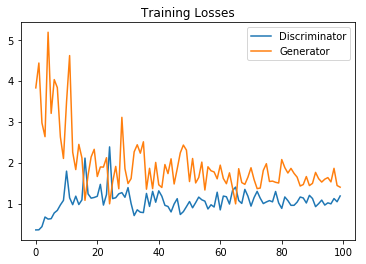

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()